# Digital Twin Fairways
This notebook provides an example on how to use the digital twin backend. It runs a simulation based on fairway information system of the Netherlands. You can define sites (with cargo), climate conditions and ships. Ships will transport the goods from A to B.

In [51]:
import datetime

import geojson
import simpy
import time

# library to load the fairway information network
import dtv_backend.network.network
# the simpy processes and objects
import dtv_backend.simple

# reload for debugging purposes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input
You can define your input in a json configuration file. The relevant parts are sites, fleet and climate.

In [52]:
# example input
with open('../dtv_backend/tests/test-01/config.json') as f:
    config = geojson.load(f)
config.keys()

dict_keys(['sites', 'fleet', 'climate', 'activities'])

## Simulation environment
Setup an simulation environment with a time that starts today. You can also choose a date in the past or future. Using the date 0 won't work on windows. 

In [53]:
# Initialize an environment with a real time
now = datetime.datetime.now()
initial_time = now.timestamp()
env = simpy.Environment(initial_time=initial_time)
env.epoch = now


## Network
Here we load the digital twin network. The topological fairway network derived from the Dutch Fairway Information System. The data is processed to be topological connected and usable for transport network analysis.  

In [54]:
url = 'https://storage.googleapis.com/et-data-science/dtv/network_digital_twin_v0.1.yaml'
G = dtv_backend.network.network.load_fis_network(url)
env.FG = G

## Connect ports to simulation environment
We have a few different entities defined. The port contains cargo and a crane. The crane can be used to load and unload cargo from ships. The site objects (later to be extended with sluices, stopping areas, etc) are geojson features. 

In [62]:
ports = []
for site in config['sites']:
    port = dtv_backend.simple.Port(env, **site['properties'], **site)
    ports.append(port)

## Connect ships to simulation environment
The ships can also contain cargo. The ships can move over the graph. They are instances of the prototype ships from the Rijkswaterstaat ship dataset. You can have multiple copies of the same ship. All ships can work at the same time. 

In [63]:
ships = []
for ship in config['fleet']:
    ship = dtv_backend.simple.Ship(env, **ship['properties'], **ship)
    ships.append(ship)


## Simulation loop
Here we define the major simulation loop. It will run for a number of steps. It will wait for ships to become available. If a ship is available it will get a new assignment.  The assignment consists of a four step procedure. sail to source, load cargo, move to destination, unload cargo. All the activities that are logged in the corresponding object.

We have three stop conditions:
- Time span (2 weeks)
- Number of iterations (n=100)
- All cargo transported 

In [65]:
class Operator(object):
    """This class represents a fleet operator."""
    def __init__(self, env, ships):
        self.env = env
        self.fleet = simpy.Store(env, capacity=len(ships))
        # create list of tasks, any ship can pick them up
        self.tasks = simpy.Store(env, capacity=len(ships))
        for ship in ships:
            self.fleet.put(ship)

    def send_task(self, task):
        """return send task request"""
        return self.tasks.put(task)

    def get_task(self):
        """return get task request"""
        return self.tasks.get()

    def run(self, source, destination):
        """A process which prepares tasks."""
        outstanding_work = 0
        while True:
            print('preparing task')
            if source.cargo.level <= 0:
                print('port empty', source.cargo.level)
                break
            if source.cargo.level - outstanding_work <= 0 :
                print('waiting for ships to return')
                # wait six hours for tasks to complete
                yield self.env.timeout(3600 * 6)
                # check again
                continue
            # Time it takes to send an assignment (1 minute)
            yield self.env.timeout(60)
            # check the maximuma load and set out tasks for that maximum load
            max_load = min(
                max(ship.max_load for ship in self.fleet.items),
                source.cargo.level - outstanding_work
            )
            self.send_task((source, destination, max_load))
            # if we set out a task with max_load, don't put more work than we have so keep track of the outstanding work
            outstanding_work += max_load


def ship(env, operator):
    """A process which consumes messages."""
    while True:
        # Get event for message pipe
        task = yield operator.get_task()
        print('got task', task)
        source, destination, max_load = task
        source.cargo.get(max_load)
        yield env.timeout(3600)
        
        
# Setup and start the simulation
env = simpy.Environment()

operator = Operator(env, ships)
env.process(operator.run(ports[0], ports[1]))
env.process(ship(env, operator))
SIM_DURATION = 3600 * 24
env.run(until=SIM_DURATION)

preparing task
preparing task
waiting for ships to return
got task (<dtv_backend.simple.Port object at 0x13fd468e0>, <dtv_backend.simple.Port object at 0x13fd46e20>, 3000)
preparing task
port empty 0


In [7]:
source, destination = ports[0], ports[1]

def loop():
    max_steps = 100
    fleet = simpy.Store(env=env, capacity=len(ships))
    for ship in ships:
        fleet.put(ship)

    for i in range(max_steps):
        if source.cargo.level <= 0:
            break
        # put all ships to work, if one of them is done, 
        # check conditions
        ship = yield fleet.get()
        env.process(ship.load_move_unload(source, destination))
        yield fleet.put(ship)
# Define the work
env.process(loop())

<Process(loop) object at 0x12bddf9a0>

In [8]:
two_weeks = now + datetime.timedelta(days=140)
env.run(until=two_weeks.timestamp())

KeyboardInterrupt: 

## Postprocessing
After the simulation is complete we can load the activity logs into a data frame and export them to our favorite formats or make charts. 

In [9]:
import pandas as pd
dfs = [pd.DataFrame(ship.log) for ship in ships]
df = pd.concat(dfs)
df['Name'] = df['Meta'].apply(lambda x: x['ship'].name)
df = df.sort_values(['Timestamp', 'AcitivityID'])


In [10]:
pd.DataFrame(ports[0].log).head()

,Message,Timestamp,Value,geometry,AcitivityID,ActivityState,Meta
0,Loading,2020-12-02 09:42:47.366782,7000,POINT (4.087406 51.936737),5,STARTED,{'destination': <dtv_backend.simple.Ship objec...
1,Loading,2020-12-02 12:42:47.366782,7000,POINT (4.087406 51.936737),302,STOPPED,{'destination': <dtv_backend.simple.Ship objec...
2,Loading,2020-12-02 12:42:47.366782,4000,POINT (4.087406 51.936737),305,STARTED,{'destination': <dtv_backend.simple.Ship objec...
3,Loading,2020-12-02 15:42:47.366782,4000,POINT (4.087406 51.936737),306,STOPPED,{'destination': <dtv_backend.simple.Ship objec...
4,Loading,2020-12-02 15:42:47.366782,1000,POINT (4.087406 51.936737),318,STARTED,{'destination': <dtv_backend.simple.Ship objec...


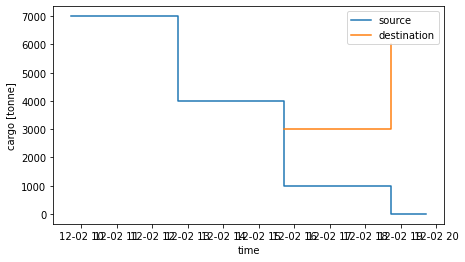

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))

source_port = pd.DataFrame(ports[0].log)
source_port['level'] = source_port['Meta'].apply(lambda x: x['source_level'])
destination_port = pd.DataFrame(ports[1].log)
destination_port['level'] = destination_port['Meta'].apply(lambda x: x['destination_level'])

ax.step(source_port['Timestamp'], source_port['level'], label='source')
ax.step(destination_port['Timestamp'], destination_port['level'], label='destination')
ax.set_ylabel('cargo [tonne]')
ax.set_xlabel('time')

ax.legend()

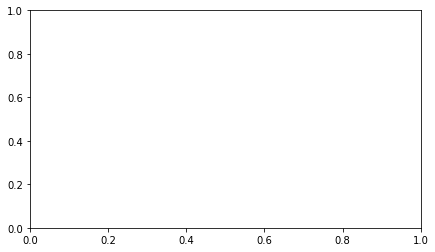

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))

for ship in ships:
    df = pd.DataFrame(ship.log)
